In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'


In [3]:
all_isc_data = pd.read_excel("isc_aes_data.xlsx", sheet_name="data_values_only")


In [4]:
#get completed students only
active_completed_students = all_isc_data[(all_isc_data["Status"] == "Active") & (all_isc_data["How much is currently complete"] == 1.00)].reset_index(drop=True)

#fix columns
active_completed_students.columns = [column.strip() for column in active_completed_students.columns]


In [5]:
#add gain, no change, loss labels
ielts_data = active_completed_students[["Centre", "StudentID", "Entry IELTS Equiv. O", "IELTS Equiv.L", "IELTS Equiv.R", "IELTS Equiv.W", "IELTS Equiv. S", "IELTS eq: Listening", "IELTS eq: Reading", "IELTS eq: Writing", "IELTS eq: Speaking", "IELTS eq: OVERALL", "Lang Gain: Listening", "Lang Gain: Reading", "Lang Gain: Writing", "Lang Gain: Speaking", "Lang Gain: OVERALL"]]

ielts_data.rename({"Entry IELTS Equiv. O": "IELTS_Overall", "IELTS Equiv.L": "IELTS_Listening", "IELTS Equiv.R": "IELTS_Reading", "IELTS Equiv.W": "IELTS_Writing", "IELTS Equiv. S": "IELTS_Speaking", "IELTS eq: Listening": "AES_Listening_IELTS", "IELTS eq: Reading": "AES_Reading_IELTS", "IELTS eq: Writing": "AES_Writing_IELTS", "IELTS eq: Speaking": "AES_Speaking_IELTS", "IELTS eq: OVERALL": "AES_Overall_IELTS"}, axis=1, inplace=True)

#print(ielts_data.columns)

def ielts_status(row):
  if row > 0:
    val = "gain"
  elif row == 0:
    val = "no change"
  else:
    val = "loss"
  return val

ielts_data["Listening_status"] = ielts_data["Lang Gain: Listening"].apply(ielts_status)
ielts_data["Reading_status"] = ielts_data["Lang Gain: Reading"].apply(ielts_status)
ielts_data["Writing_status"] = ielts_data["Lang Gain: Writing"].apply(ielts_status)
ielts_data["Speaking_status"] = ielts_data["Lang Gain: Speaking"].apply(ielts_status)
ielts_data["Overall_status"] = ielts_data["Lang Gain: OVERALL"].apply(ielts_status)




In [6]:
#fix <4.5
ielts_data.replace({"<4.5": 4.0}, inplace=True)

#fix non-numeric
ielts_data.drop(index=1250, inplace=True)

#fix overall column
ielts_data["IELTS_Overall"] = ielts_data["IELTS_Overall"].astype("float")


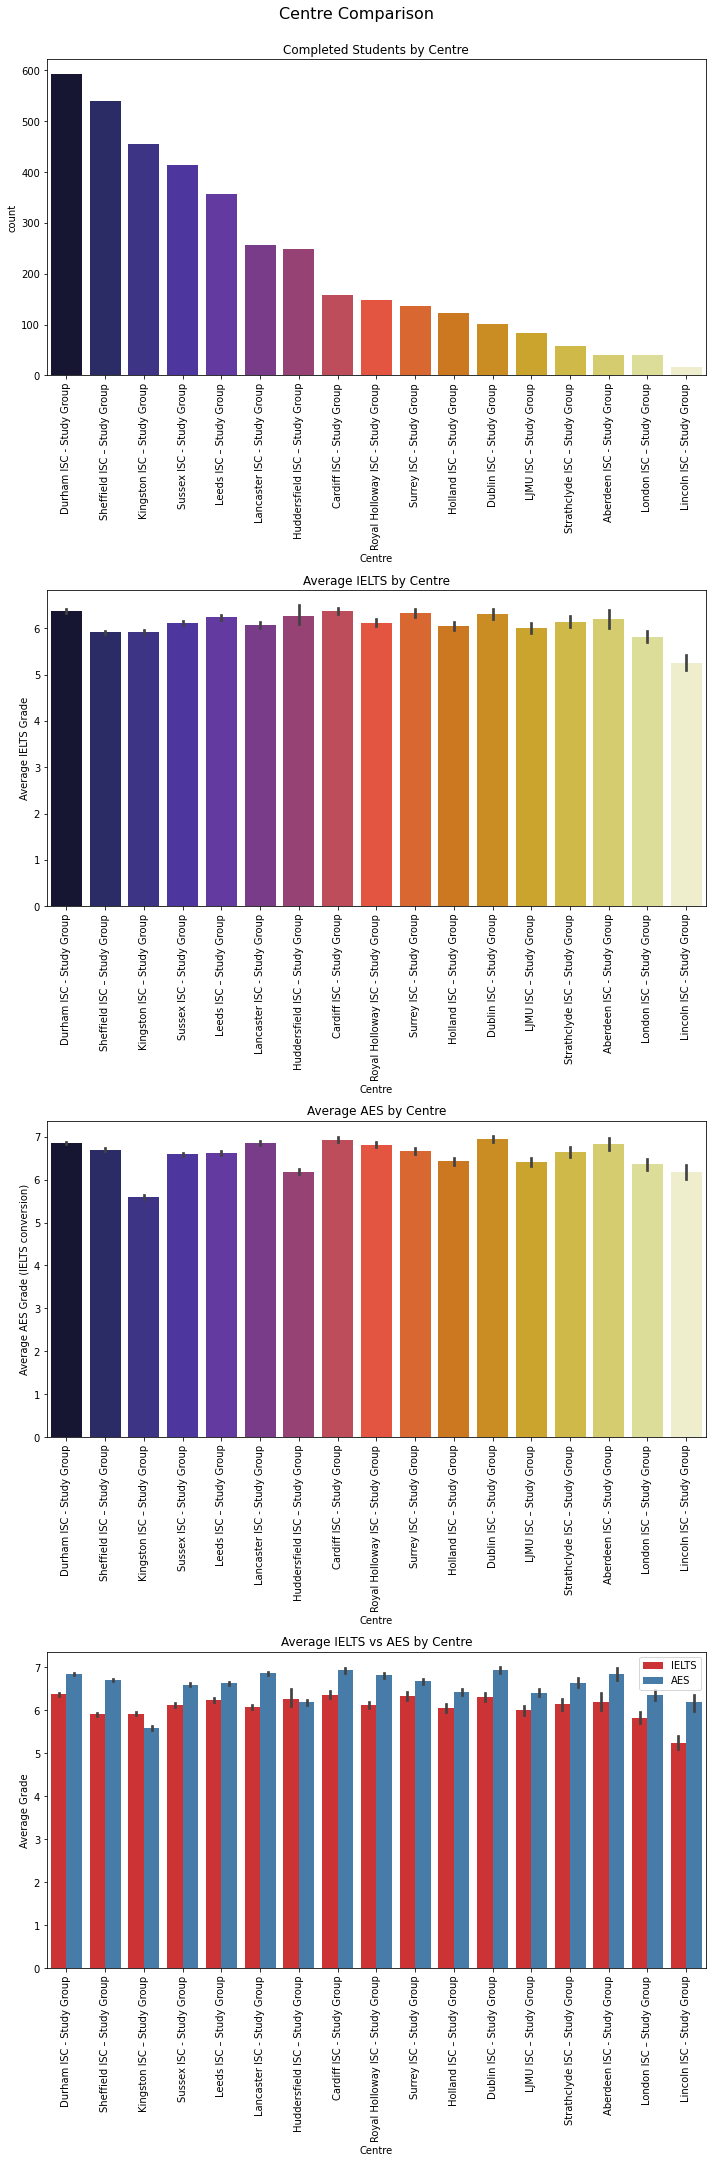

In [7]:
#plot centre info
order = ielts_data["Centre"].value_counts().index


ielts_melt = pd.melt(ielts_data[["Centre", "IELTS_Overall", "IELTS_Listening", "IELTS_Reading", "IELTS_Writing", "IELTS_Speaking"]], id_vars=["Centre"], var_name="Assessment", value_name="Grade")
aes_melt = pd.melt(ielts_data[["Centre", "AES_Overall_IELTS", "AES_Listening_IELTS", "AES_Reading_IELTS", "AES_Writing_IELTS", "AES_Speaking_IELTS"]], id_vars=["Centre"], var_name="Assessment", value_name="Grade")

ielts_melt["type"] = "IELTS"
aes_melt["type"] = "AES"

exam_types = pd.concat([ielts_melt, aes_melt])


fig, axs = plt.subplots(4,1, figsize=(10,30))
fig.suptitle("Centre Comparison", y=1, fontsize=16)
sns.countplot(x="Centre", data=ielts_data, order=order, palette="CMRmap", ax=axs[0])
axs[0].set_xticklabels(labels=order, rotation=90, ha="center")
axs[0].set_title("Completed Students by Centre")

sns.barplot(x="Centre", y="Grade", data=ielts_melt, ax=axs[1], order=order, palette="CMRmap")
axs[1].set_xticklabels(labels=order, rotation=90, ha="center")
axs[1].set_ylabel("Average IELTS Grade")
axs[1].set_title("Average IELTS by Centre")

sns.barplot(x="Centre", y="Grade", data=aes_melt, ax=axs[2], order=order, palette="CMRmap")
axs[2].set_xticklabels(labels=order, rotation=90, ha="center")
axs[2].set_ylabel("Average AES Grade (IELTS conversion)")
axs[2].set_title("Average AES by Centre")

compare = sns.color_palette(['#e41a1c','#377eb8','#4daf4a'])

sns.barplot(x="Centre", y="Grade", data=exam_types, hue="type", ax=axs[3], order=order, palette=compare)
axs[3].set_xticklabels(labels=order, rotation=90, ha="center")
axs[3].set_ylabel("Average Grade")
axs[3].set_title("Average IELTS vs AES by Centre")
axs[3].legend(loc="upper right")

plt.tight_layout()
plt.show()

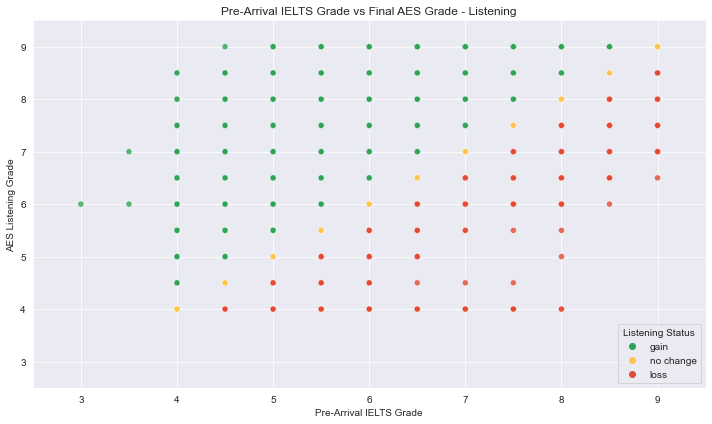

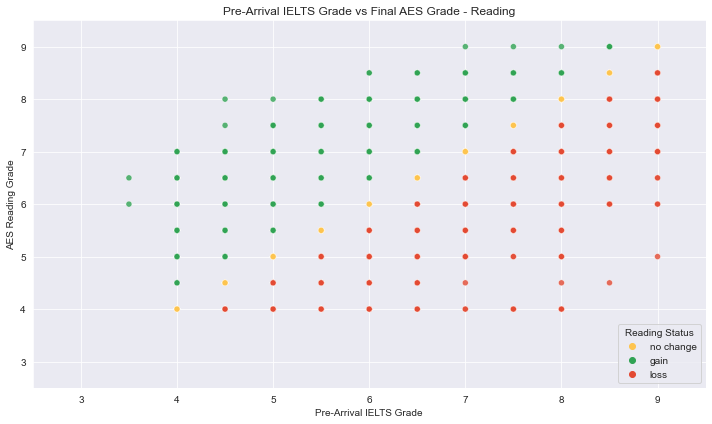

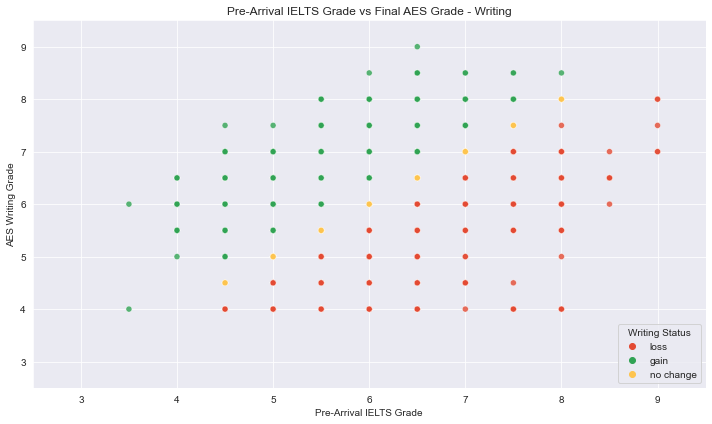

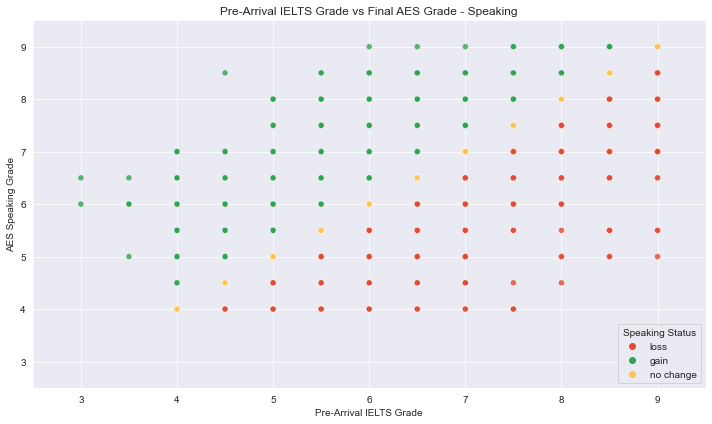

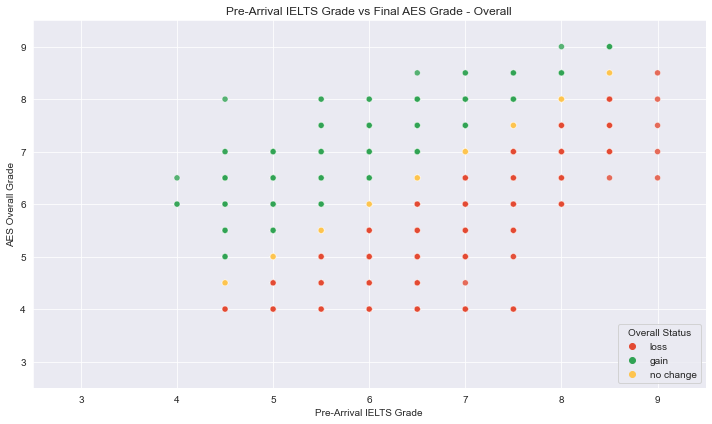

In [8]:
#plot IELTS gain data
palette ={"gain": "#31a354", "no change": "#fec44f", "loss": "#e34a33"}
sns.set_style("darkgrid")


def plot_scatter(skills):
  i = 0
  for skill in skills:
    fig, axs = plt.subplots(1, figsize=(10,6))
    sns.scatterplot(y="AES_{}_IELTS".format(skill), x= "IELTS_{}".format(skill), hue="{}_status".format(skill), data=ielts_data, palette=palette, alpha=0.8)
    axs.set_ylabel("AES {} Grade".format(skill.capitalize()))
    axs.set_xlabel("Pre-Arrival IELTS Grade")
    axs.set_xlim(2.5, 9.5)
    axs.set_ylim(2.5, 9.5)
    axs.set_title("Pre-Arrival IELTS Grade vs Final AES Grade - {}".format(skill.capitalize()))
    axs.legend(title="{} Status".format(skill.capitalize()), loc="lower right")
    plt.tight_layout()
    #plt.savefig("charts/IELTS vs AES - {}".format(skill))
    plt.show()
    i += 1

plot_scatter(["Listening", "Reading", "Writing", "Speaking", "Overall"])

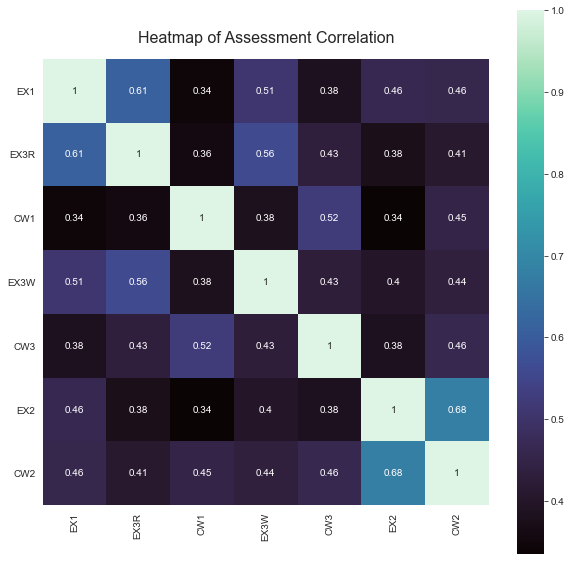

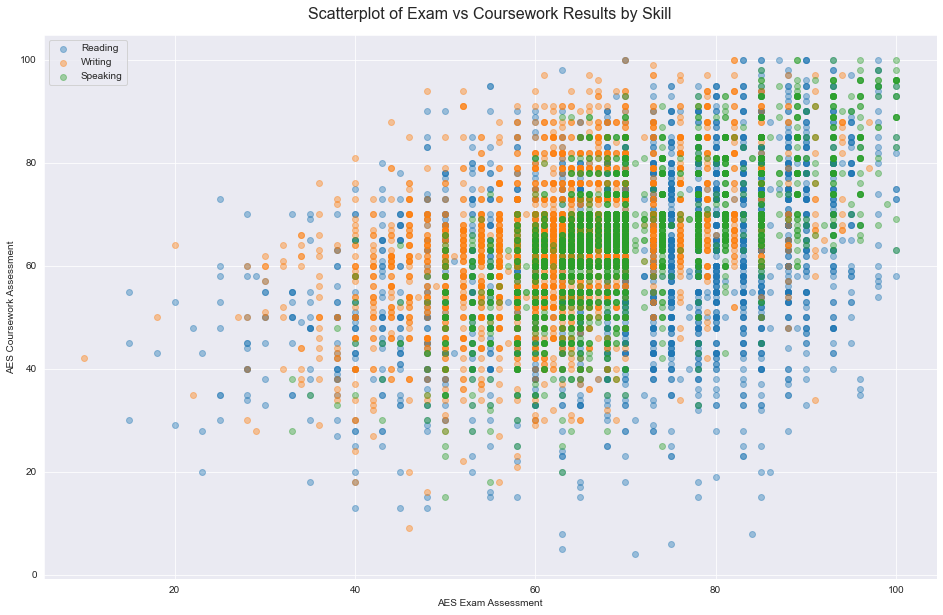

In [9]:
#get assessment data
assessment_data = active_completed_students[["EX1", "EX3R", "CW1", "EX3W", "CW3", "EX2", "CW2"]].reset_index(drop=True)

assessment_data.replace(0, np.nan, inplace=True)
#assessment_data.fillna(assessment_data.mean(), inplace=True)
assessment_data.dropna(how="any", inplace=True)

corr = assessment_data.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap="mako", ax=ax, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("Heatmap of Assessment Correlation", fontsize=16, pad=16)


plt.show()

fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(x="EX3R", y="CW1", data=assessment_data, alpha=0.4, label="Reading")
ax.scatter(x="EX3W", y="CW3", data=assessment_data, alpha=0.4, label="Writing")
ax.scatter(x="EX2", y="CW2", data=assessment_data, alpha=0.4, label="Speaking")
ax.set_xlabel("AES Exam Assessment")
ax.set_ylabel("AES Coursework Assessment")
ax.legend()
ax.set_title("Scatterplot of Exam vs Coursework Results by Skill", fontsize=16, pad=16)
plt.show()



#sns.pairplot(assessment_data, plot_kws={"alpha": 0.5})
#plt.show()



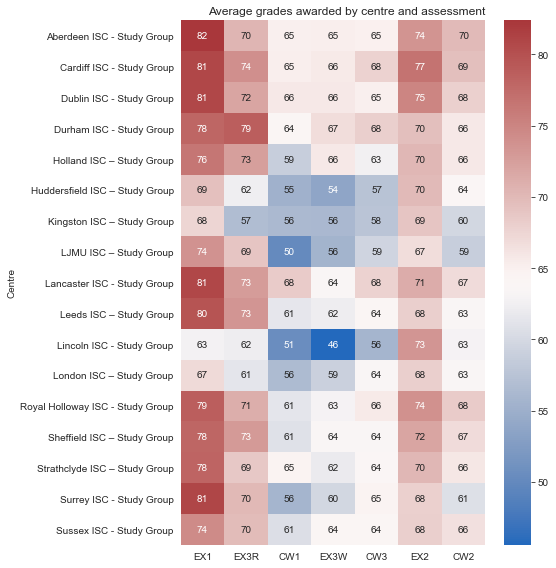

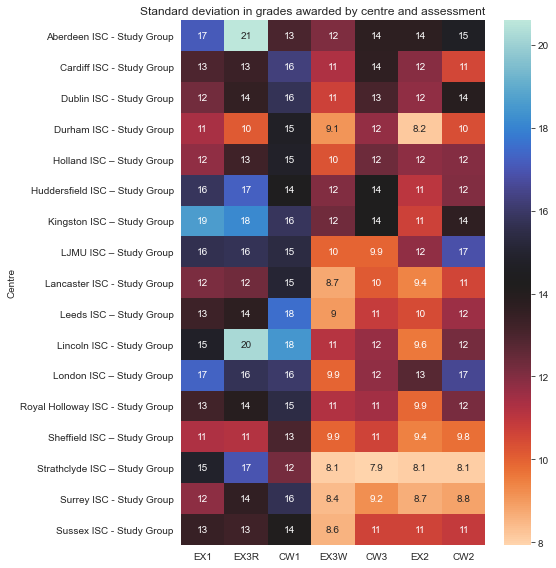

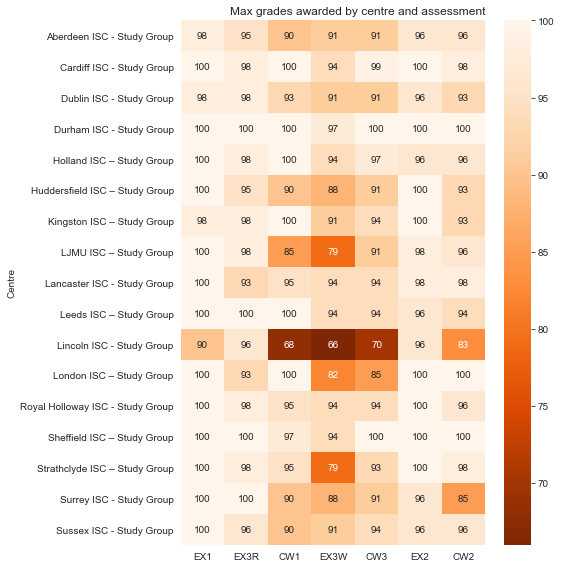

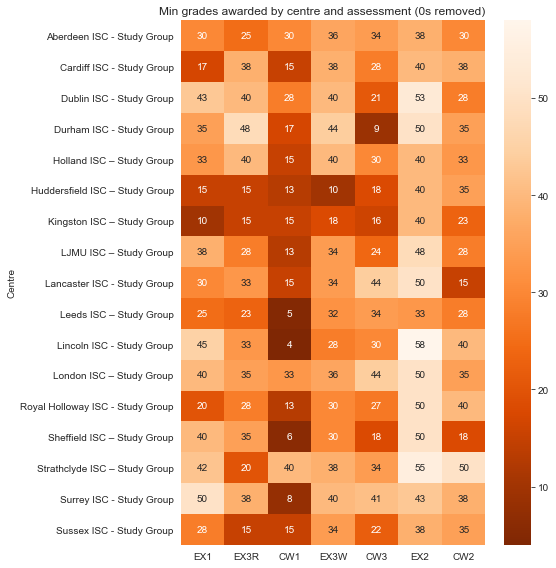

In [10]:
assessment_data_by_centre = active_completed_students[["Centre", "EX1", "EX3R", "CW1", "EX3W", "CW3", "EX2", "CW2"]]

assessment_data_by_centre.replace(0, np.nan, inplace=True)
assessment_data_by_centre.dropna(how="any", inplace=True)

grouped_mean = assessment_data_by_centre.groupby(by="Centre").mean()

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Average grades awarded by centre and assessment", fontsize=12, loc="right")
sns.heatmap(grouped_mean, annot=True, cmap="vlag", ax=ax)
plt.tight_layout()
plt.savefig("averages.png")

plt.show()


grouped_std = assessment_data_by_centre.groupby(by="Centre").std()

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Standard deviation in grades awarded by centre and assessment", fontsize=12, loc="right")
sns.heatmap(grouped_std, annot=True, cmap="icefire_r", ax=ax)
plt.tight_layout()
plt.savefig("std.png")

plt.show()


grouped_max = assessment_data_by_centre.groupby(by="Centre").max()

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Max grades awarded by centre and assessment", fontsize=12, loc="right")
sns.heatmap(grouped_max, annot=True, cmap="Oranges_r", ax=ax, fmt="g")
plt.tight_layout()
plt.savefig("max.png")

plt.show()


grouped_min = assessment_data_by_centre.groupby(by="Centre").min()

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Min grades awarded by centre and assessment (0s removed)", fontsize=12, loc="right")
sns.heatmap(grouped_min, annot=True, cmap="Oranges_r", ax=ax, fmt="g")
plt.tight_layout()
plt.savefig("min.png")

plt.show()



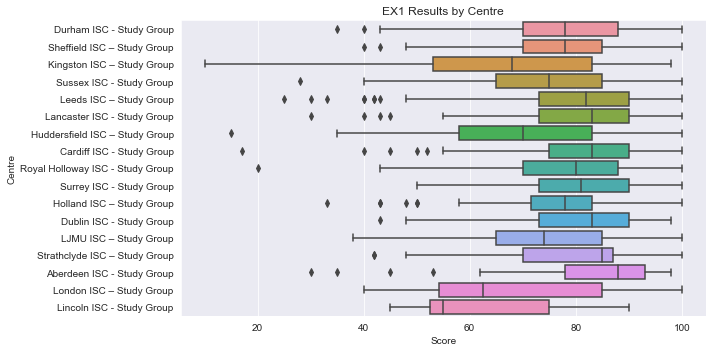

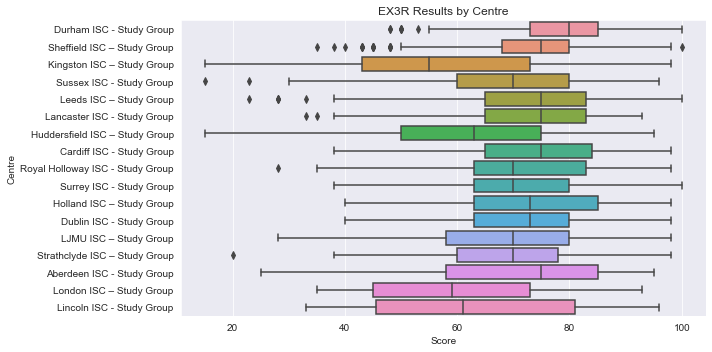

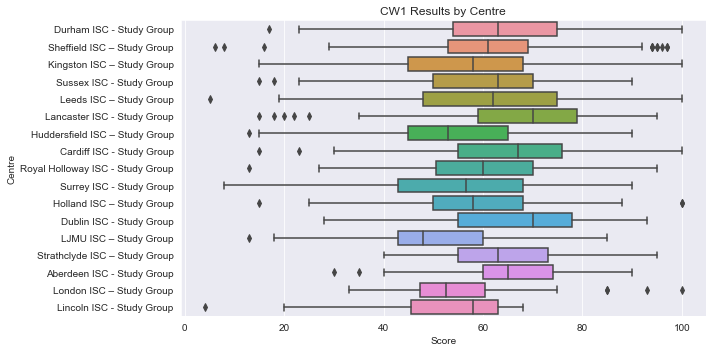

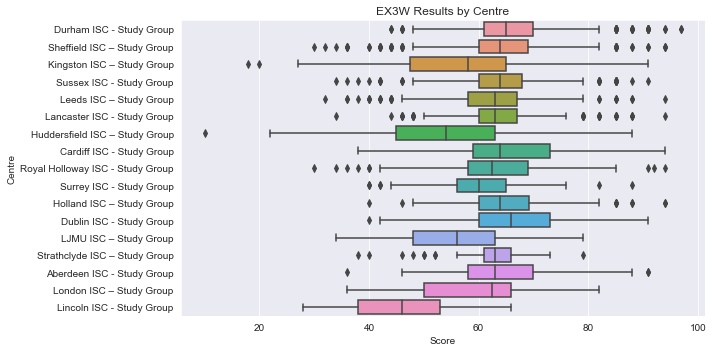

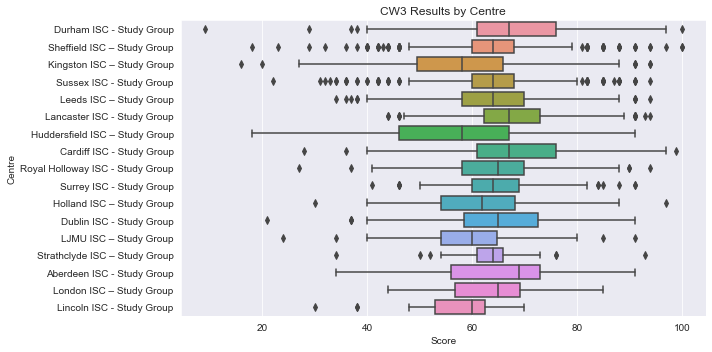

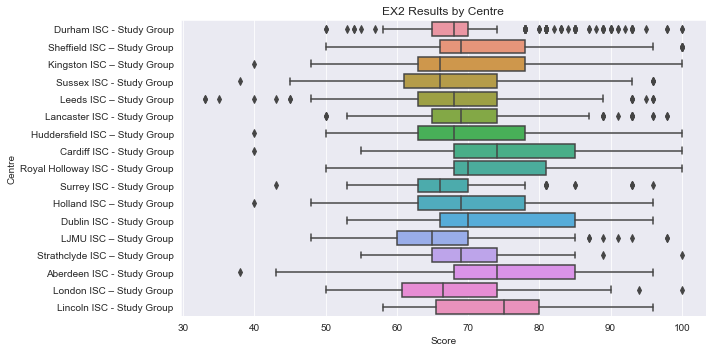

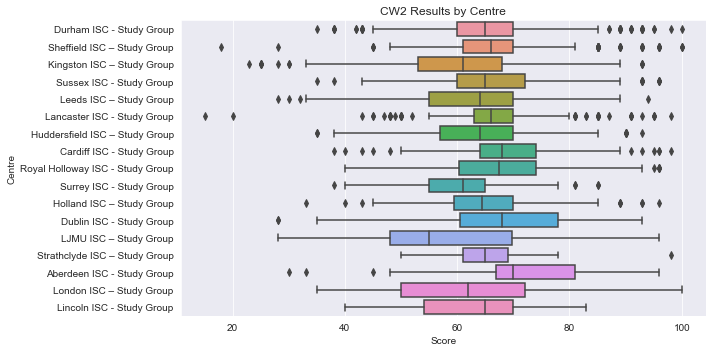

In [11]:
#describe the results

grouped_describe = assessment_data_by_centre.groupby(by="Centre").describe()
grouped_describe = grouped_describe.sort_values(by=[("EX1", "count")], ascending=False)


writer = pd.ExcelWriter("Results Overview By Centre.xlsx", engine="xlsxwriter")
workbook = writer.book

for assessment in grouped_describe.columns.levels[0]:
  data = grouped_describe[assessment]
  max_row, max_col = data.shape
  data.to_excel(writer, sheet_name=assessment, index=True)
  column_settings = [{"header": column} for column in data.columns]
  column_settings.insert(0, {"header": "Centre"})
  sheet = writer.sheets[assessment]
  sheet.add_table(0,0, max_row, max_col, {"columns": column_settings, "style": "Table Style Medium 5"})
  sheet.set_column(0, 0, 40)
  fig, ax = plt.subplots(figsize=(10,5))
  sns.boxplot(y="Centre", x=assessment, data=assessment_data_by_centre, order=order)
  ax.set_title("{} Results by Centre".format(assessment))
  ax.set_xlabel("Score")
  plt.tight_layout()
  plt.savefig("{}.png".format(assessment))
  sheet.insert_image("K1", "{}.png".format(assessment))
  

charts = workbook.add_worksheet("Charts")

charts.insert_image("A1","averages.png")
charts.insert_image("J1","std.png")
charts.insert_image("A21","max.png")
charts.insert_image("J21","min.png")

writer.save()
  





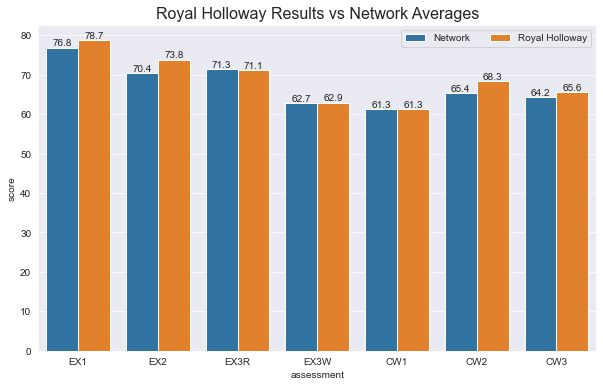

In [110]:
#comparing RH to network averages
average_aes_grades = assessment_data_by_centre.mean().reset_index().rename({"index": "assessment", 0: "score"}, axis=1)
average_aes_grades["centre"] = "Network"
rh_grades = assessment_data_by_centre[assessment_data_by_centre["Centre"] == "Royal Holloway ISC - Study Group"].mean().reset_index().rename({"index": "assessment", 0: "score"}, axis=1)
rh_grades["centre"] = "Royal Holloway"

plotting_data = pd.concat([average_aes_grades, rh_grades])

fig, ax = plt.subplots(1, figsize=(10,6))
ax.set_title("Royal Holloway Results vs Network Averages", fontsize=16)
sns.barplot(data=plotting_data, x="assessment", y="score", hue="centre", order=["EX1", "EX2", "EX3R", "EX3W", "CW1", "CW2", "CW3"], ax=ax)
for bar in ax.containers:
  ax.bar_label(bar, label_type="edge", fmt="%.1f")
ax.legend(ncol=2)

plt.show()




In [13]:
#remove RH data from the assessment data df
ml_data = assessment_data_by_centre[assessment_data_by_centre["Centre"] != "Royal Holloway ISC - Study Group"]


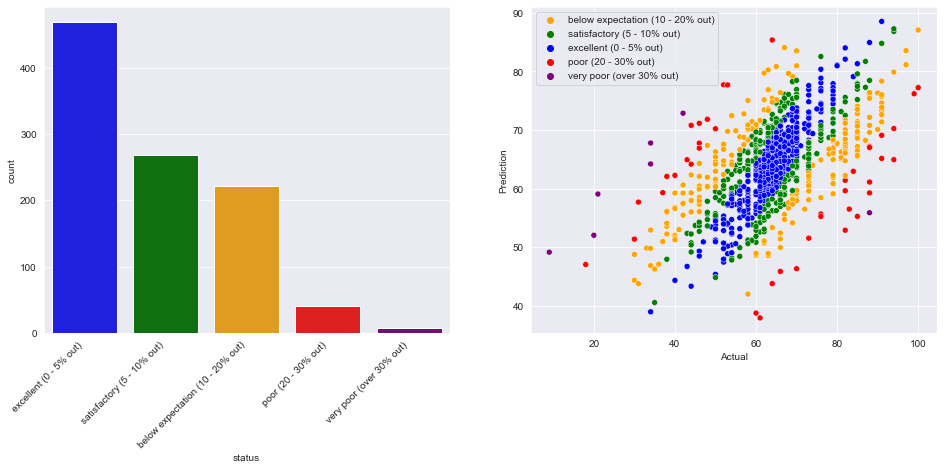

In [14]:
#train linear regression model to predict CW3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


#features
features_array = np.array(ml_data[["EX3W", "EX1", "EX2", "CW2", "CW1", "EX3R"]])


#labels
labels_array = np.array(ml_data["CW3"])


X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.33, random_state=0)



regr = LinearRegression(normalize=True)


regr.fit(X_train, y_train)

predictions = regr.predict(X_test)

df = pd.DataFrame(y_test, columns=["Actual"])
df2 = pd.DataFrame(predictions, columns=["Prediction"])

new_df = df.join(df2)

def status(row):
  if row > 30:
    val = "very poor (over 30% out)"
  elif row > 20:
    val = "poor (20 - 30% out)"
  elif row > 10:
    val = "below expectation (10 - 20% out)"
  elif row > 5:
    val = "satisfactory (5 - 10% out)"
  else:
    val = "excellent (0 - 5% out)"
  return val

new_df["diff"] = abs(new_df["Actual"] - new_df["Prediction"])
new_df["status"] = new_df["diff"].apply(status)

#bars

#scatters
fig, axs = plt.subplots(1,2,figsize=(16,6))

palette = {"excellent (0 - 5% out)": "blue", "satisfactory (5 - 10% out)": "green", "below expectation (10 - 20% out)": "orange", "poor (20 - 30% out)": "red", "very poor (over 30% out)": "purple"}

sns.countplot(x="status", data=new_df, palette=palette, order=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], ax=axs[0])
axs[0].set_xticklabels(labels=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], rotation=45, ha="right")

sns.scatterplot(x="Actual", y="Prediction", hue="status", data=new_df, palette=palette, ax=axs[1])
plt.legend()
plt.show()





[('CW3', 0.3929248740338359), ('EX2', 0.4881864662884975), ('EX1', 0.45491769920026603), ('CW1', 0.3614994138264155), ('CW2', 0.5426719242334798), ('EX3R', 0.48271915871705373), ('EX3W', 0.42056913789553274)]


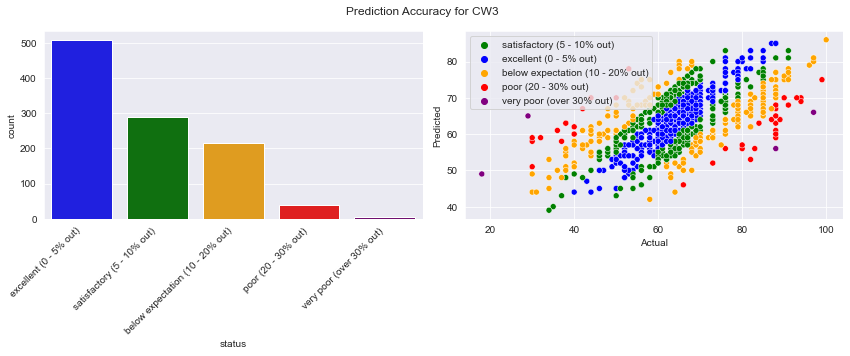

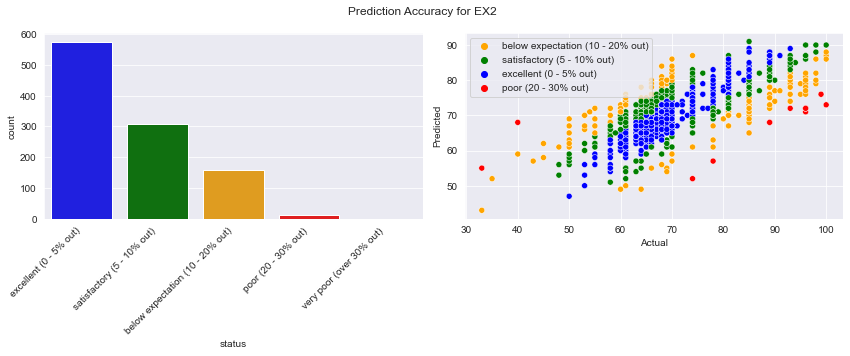

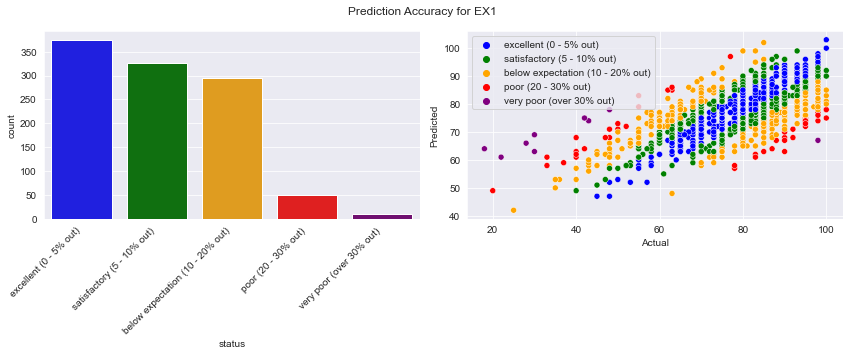

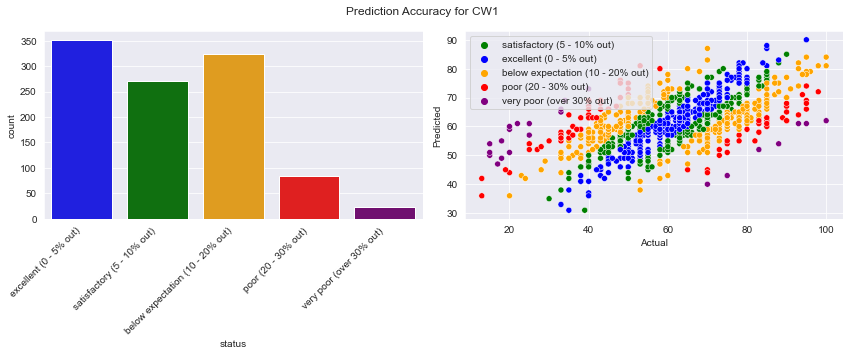

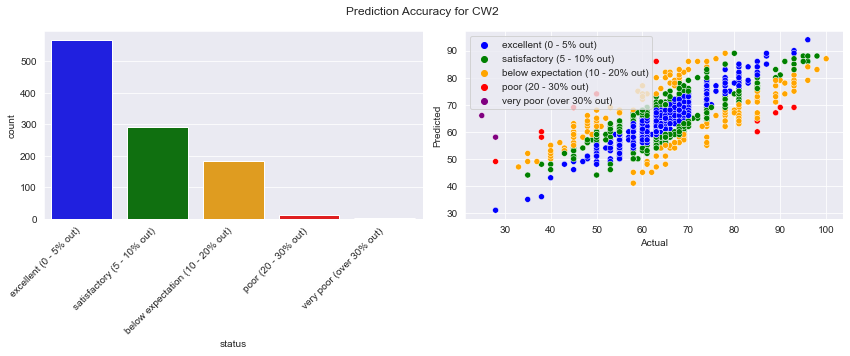

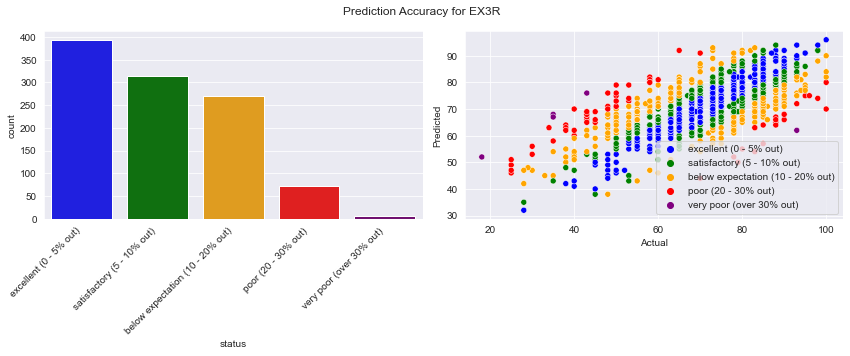

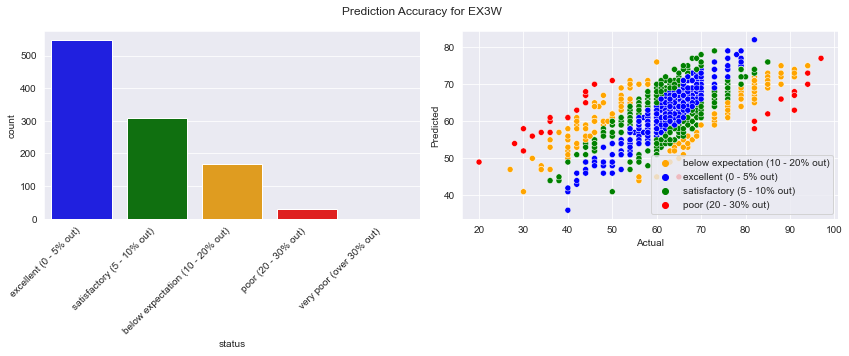

In [15]:
#train linear regression model to predict different scores
from scipy import stats
#writer for Excel
writer = pd.ExcelWriter("predicted_grades.xlsx", engine="xlsxwriter")
scores = []
def predict_scores(assessment):
  #create features
  all_features = assessment_data[["CW3", "EX3W", "EX1", "EX2", "CW2", "CW1", "EX3R"]]
  #all_features = all_features[(np.abs(stats.zscore(all_features)) < 3).all(axis=1)]
  features = all_features.drop(assessment, axis=1)
  features = np.array(features)

  #create labels
  labels = np.array(all_features[assessment])

  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)

  #create regression model
  regr = LinearRegression()
  #fit model
  regr.fit(X_train, y_train)
  #make predictions
  predictions = regr.predict(X_test)
  #get score
  scores.append((assessment, regr.score(X_test, y_test)))

  #create df
  df = pd.DataFrame({"Actual": y_test, "Predicted": np.round_(predictions, decimals=0), "Difference": abs(y_test - predictions)})

  def status(row):
    if row > 30:
      val = "very poor (over 30% out)"
    elif row > 20:
      val = "poor (20 - 30% out)"
    elif row > 10:
      val = "below expectation (10 - 20% out)"
    elif row > 5:
      val = "satisfactory (5 - 10% out)"
    else:
      val = "excellent (0 - 5% out)"
    return val

  df["status"] = df["Difference"].apply(status)

  #scatters
  fig, axs = plt.subplots(1,2,figsize=(12,5))
  fig.suptitle("Prediction Accuracy for {}".format(assessment))

  palette = {"excellent (0 - 5% out)": "blue", "satisfactory (5 - 10% out)": "green", "below expectation (10 - 20% out)": "orange", "poor (20 - 30% out)": "red", "very poor (over 30% out)": "purple"}

  sns.countplot(x="status", data=df, palette=palette, order=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], ax=axs[0])
  axs[0].set_xticklabels(labels=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], rotation=45, ha="right")

  sns.scatterplot(x="Actual", y="Predicted", hue="status", data=df, palette=palette, ax=axs[1])
  plt.legend()
  plt.tight_layout()
  plt.savefig("{}_predictions.png".format(assessment))

  #save to excel
  df.to_excel(writer, sheet_name=assessment, index=False)
  workbook = writer.book
  max_row, max_col = df.shape
  column_settings = [{"header": column} for column in df.columns]
  sheet = writer.sheets[assessment]
  sheet.add_table(0,0, max_row, max_col -1, {"columns": column_settings, "style": "Table Style Medium 5"})
  sheet.set_column(max_col - 2, max_col - 2, 30) 
  sheet.set_column(max_col - 1, max_col - 1, 50) 
  sheet.insert_image("F1", "{}_predictions.png".format(assessment))

  excellent = workbook.add_format({"bg_color": "#3C4EFE", "color": "white", "bold": 1})
  sat = workbook.add_format({"bg_color": "#27CB37", "bold": 1})
  below_exp = workbook.add_format({"bg_color": "#FFC000", "bold": 1})
  poor = workbook.add_format({"bg_color": "#DA0404", "color": "white", "bold": 1})
  v_poor = workbook.add_format({"bg_color": "#6E286B", "color": "white", "bold": 1})

  formats = [excellent, sat, below_exp, poor, v_poor]
  i = 0

  for entry in ["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"]:
    sheet.conditional_format("D2:D{}".format(max_row + 1), {'type': 'cell', 'criteria': 'equal to', 'value': '"{}"'.format(entry), 'format': formats[i]})
    i += 1


predict_scores("CW3")
predict_scores("EX2")
predict_scores("EX1")
predict_scores("CW1")
predict_scores("CW2")
predict_scores("EX3R")
predict_scores("EX3W")

writer.save()

print(scores)

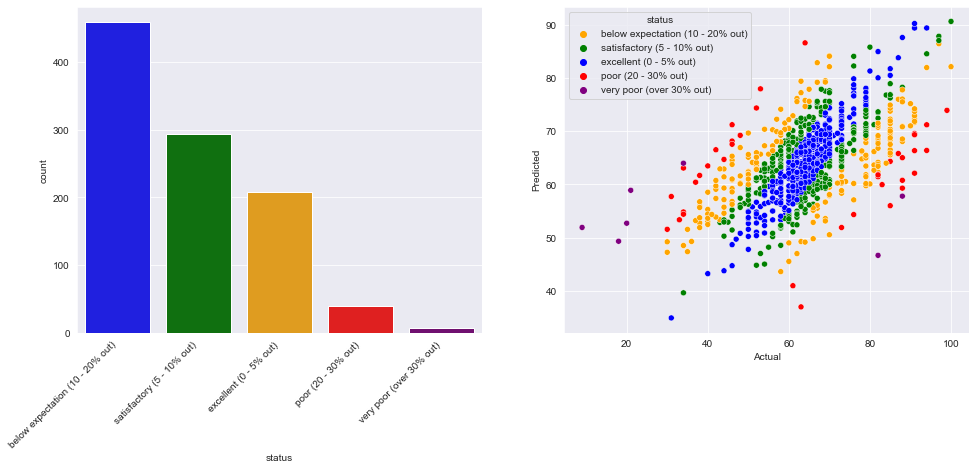

In [16]:
#Random Forest regression
from sklearn.ensemble import RandomForestRegressor

regr_forest = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)

regr_forest.fit(X_train, y_train.ravel())

score = regr_forest.score(X_test, y_test)


predictions = regr_forest.predict(X_test)


df_a_p = pd.DataFrame({"Actual": y_test, "Predicted": predictions, "diff": abs(y_test - predictions)})
df_a_p["status"] = df_a_p["diff"].apply(status)

fig, axs = plt.subplots(1,2,figsize=(16,6))
sns.countplot(x="status", data=df_a_p, ax=axs[0], order=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], palette=palette)
axs[0].set_xticklabels(labels=df_a_p.status.unique(), rotation=45, ha="right")
sns.scatterplot(x="Actual", y="Predicted", data=df_a_p, hue="status", ax=axs[1], palette=palette)
plt.show()


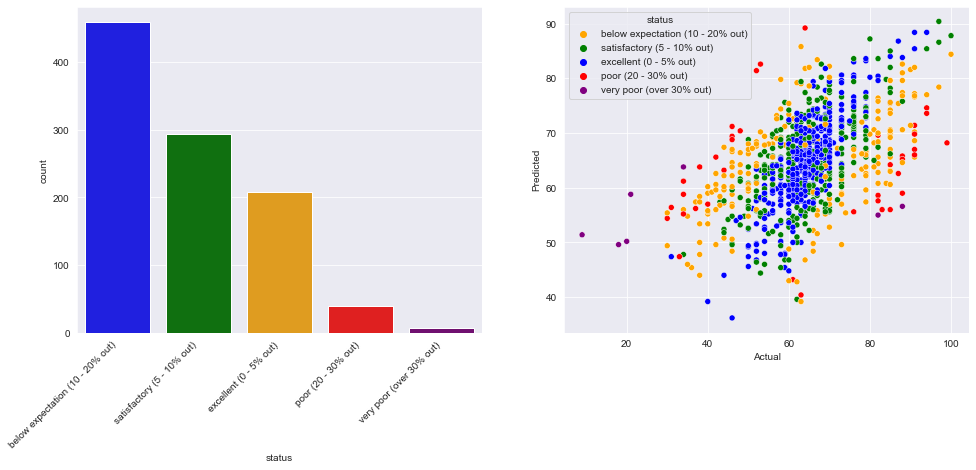

In [17]:
from sklearn.neighbors import KNeighborsRegressor

kn_regr = KNeighborsRegressor()

kn_regr.fit(X_train, y_train)

predictions_n = kn_regr.predict(X_test)

ma_error_n = mean_absolute_error(y_test, predictions)
rms_error_n = mean_squared_error(y_test, predictions)
r2_score_n = r2_score(y_test, predictions)

#scatter and bar
df_ax_px = pd.DataFrame({"Actual": y_test, "Predicted": predictions_n, "diff": abs(y_test - predictions)})
df_ax_px["status"] = df_a_p["diff"].apply(status)

fig, axs = plt.subplots(1,2,figsize=(16,6))
sns.countplot(x="status", data=df_ax_px, ax=axs[0], order=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], palette=palette)
axs[0].set_xticklabels(labels=df_a_p.status.unique(), rotation=45, ha="right")
sns.scatterplot(x="Actual", y="Predicted", data=df_ax_px, hue="status", ax=axs[1], palette=palette)
plt.show()


In [18]:
#RH data

rh_data = pd.read_excel("../all_student_data.xlsx")

rh_data.replace(0, np.nan, inplace=True)
rh_data.dropna(how="any", inplace=True)

model_features = np.array(rh_data[["EX1 Listening", "EX2 Speaking", "EX3 Reading", "EX3 Writing", "CW1", "CW2"]])
actual_scores = np.array(rh_data["CW3"])


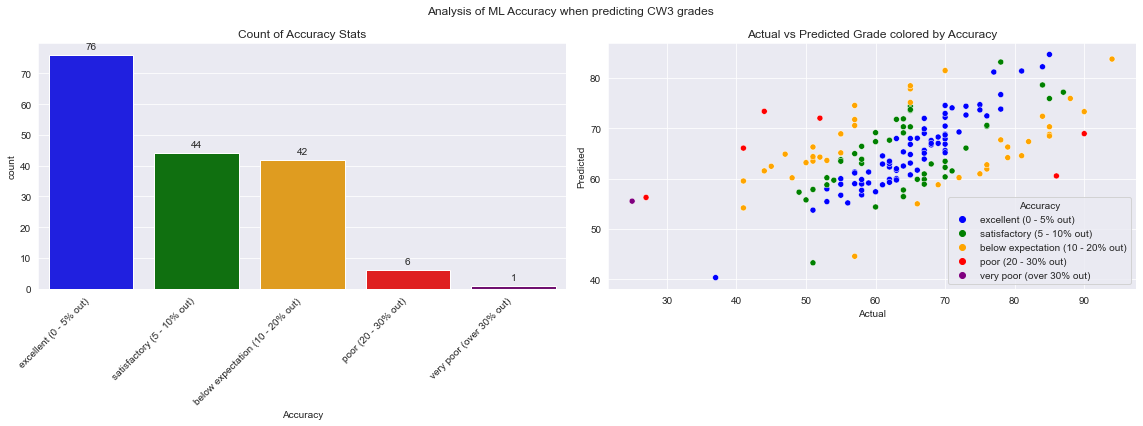

In [19]:
#liner model  with RH data
linear_pred = regr.predict(model_features)

#create df
linear_df = pd.DataFrame({"Full Name": rh_data["Full Name"], "Actual": actual_scores, "Predicted": linear_pred, "Difference": abs(actual_scores - linear_pred)})
linear_df["Accuracy"] = linear_df["Difference"].apply(status)

#plot charts
#scatter and bar
fig, axs = plt.subplots(1,2,figsize=(16,6))
sns.countplot(x="Accuracy", data=linear_df, ax=axs[0], order=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], palette=palette)
fig.suptitle("Analysis of ML Accuracy when predicting CW3 grades")
axs[0].set_xticklabels(labels=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], rotation=45, ha="right")
axs[0].bar_label(axs[0].containers[0], padding=4)
axs[0].set_title("Count of Accuracy Stats")
sns.scatterplot(x="Actual", y="Predicted", data=linear_df, hue="Accuracy", ax=axs[1], palette=palette)
axs[1].set_title("Actual vs Predicted Grade colored by Accuracy")
plt.tight_layout()
plt.savefig("../linear_charts.png")


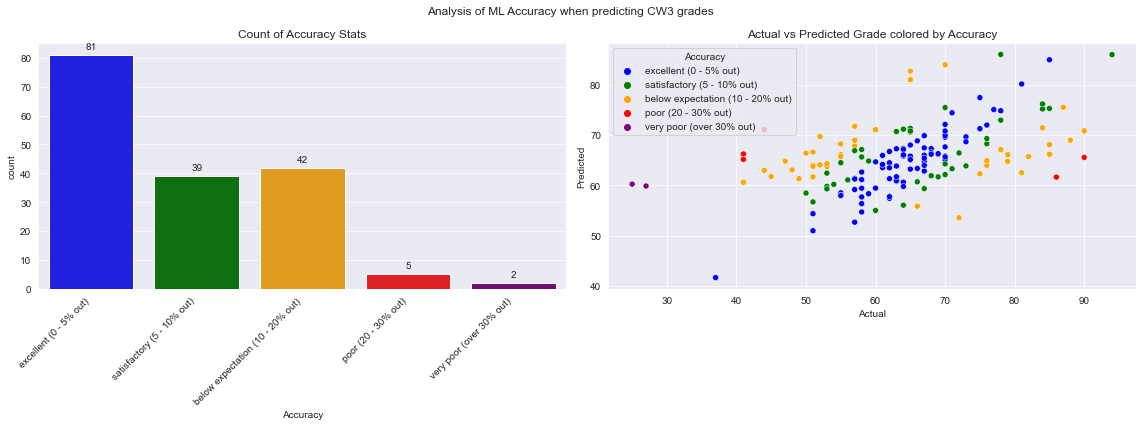

In [20]:
#random forest test with RH data
forest_pred = regr_forest.predict(model_features)

#create df
forest_df = pd.DataFrame({"Full Name": rh_data["Full Name"], "Actual": actual_scores, "Predicted": forest_pred, "Difference": abs(actual_scores - forest_pred)})
forest_df["Accuracy"] = forest_df["Difference"].apply(status)

#plot charts
#scatter and bar
fig, axs = plt.subplots(1,2,figsize=(16,6))
sns.countplot(x="Accuracy", data=forest_df, ax=axs[0], order=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], palette=palette)
fig.suptitle("Analysis of ML Accuracy when predicting CW3 grades")
axs[0].set_xticklabels(labels=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], rotation=45, ha="right")
axs[0].bar_label(axs[0].containers[0], padding=4)
axs[0].set_title("Count of Accuracy Stats")
sns.scatterplot(x="Actual", y="Predicted", data=forest_df, hue="Accuracy", ax=axs[1], palette=palette)
axs[1].set_title("Actual vs Predicted Grade colored by Accuracy")
plt.tight_layout()
plt.savefig("../forest_charts.png")


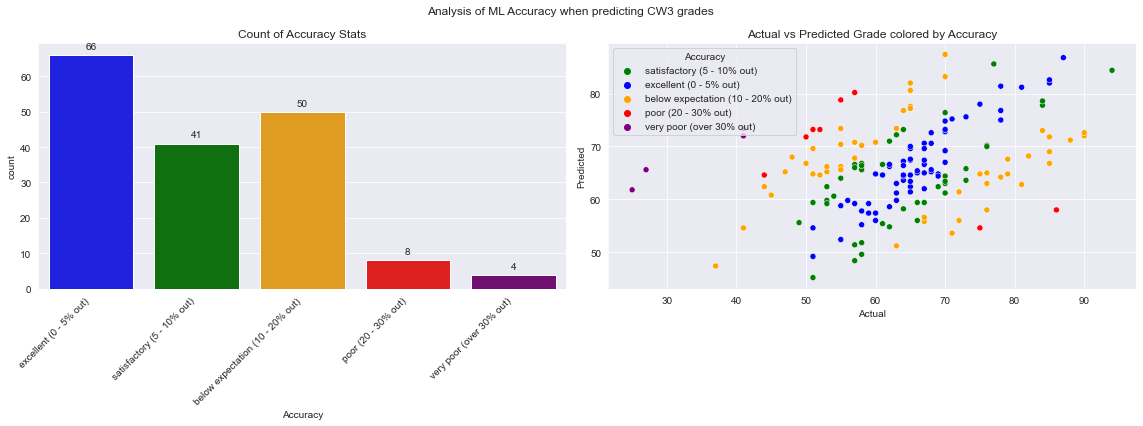

In [21]:
#KNN test with RH data
knn_pred = kn_regr.predict(model_features)

#create df
knn_df = pd.DataFrame({"Full Name": rh_data["Full Name"], "Actual": actual_scores, "Predicted": knn_pred, "Difference": abs(actual_scores - knn_pred)})
knn_df["Accuracy"] = knn_df["Difference"].apply(status)

#plot charts
#scatter and bar
fig, axs = plt.subplots(1,2,figsize=(16,6))
sns.countplot(x="Accuracy", data=knn_df, ax=axs[0], order=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], palette=palette)
fig.suptitle("Analysis of ML Accuracy when predicting CW3 grades")
axs[0].set_xticklabels(labels=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], rotation=45, ha="right")
axs[0].bar_label(axs[0].containers[0], padding=4)
axs[0].set_title("Count of Accuracy Stats")
sns.scatterplot(x="Actual", y="Predicted", data=knn_df, hue="Accuracy", ax=axs[1], palette=palette)
axs[1].set_title("Actual vs Predicted Grade colored by Accuracy")
plt.tight_layout()
plt.savefig("../knn_charts.png")


In [22]:

#create excel doc
writer = pd.ExcelWriter("../cw3_predictions.xlsx", engine="xlsxwriter")
linear_df.to_excel(writer, sheet_name="ML Linear Model", index=False)
forest_df.to_excel(writer, sheet_name="ML Random Forest Model", index=False)
knn_df.to_excel(writer, sheet_name="ML K Nearest Neighbors Model", index=False)


workbook = writer.book
worksheet1 = writer.sheets["ML Linear Model"]
worksheet2 = workbook.add_worksheet("Linear Charts")
worksheet3 = writer.sheets["ML Random Forest Model"]
worksheet4 = workbook.add_worksheet("Random Forest Charts")
worksheet5 = writer.sheets["ML K Nearest Neighbors Model"]
worksheet6 = workbook.add_worksheet("K Nearest Neighbors Charts")


(max_row_1, max_col_1) = linear_df.shape
column_settings_1 = [{"header": column} for column in linear_df.columns]

(max_row_2, max_col_2) = forest_df.shape
column_settings_2 = [{"header": column} for column in forest_df.columns]

(max_row_3, max_col_3) = knn_df.shape
column_settings_3 = [{"header": column} for column in knn_df.columns]


worksheet1.add_table(0,0, max_row_1, max_col_1 - 1, {"columns": column_settings_1, "style": "Table Style Light 8"})
worksheet1.set_column(0, max_col_1, 30)

worksheet3.add_table(0,0, max_row_2, max_col_2 - 1, {"columns": column_settings_2, "style": "Table Style Light 8"})
worksheet3.set_column(0, max_col_2, 30)

worksheet5.add_table(0,0, max_row_3, max_col_3 - 1, {"columns": column_settings_3, "style": "Table Style Light 8"})
worksheet5.set_column(0, max_col_3, 30)

excellent = workbook.add_format({"bg_color": "#3C4EFE", "color": "white", "bold": 1})
sat = workbook.add_format({"bg_color": "#27CB37", "bold": 1})
below_exp = workbook.add_format({"bg_color": "#FFC000", "bold": 1})
poor = workbook.add_format({"bg_color": "#DA0404", "color": "white", "bold": 1})
v_poor = workbook.add_format({"bg_color": "#6E286B", "color": "white", "bold": 1})

formats = [excellent, sat, below_exp, poor, v_poor]
i = 0

for entry in ["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"]:
  worksheet1.conditional_format("E2:E{}".format(max_row_1 + 1), {'type': 'cell', 'criteria': 'equal to', 'value': '"{}"'.format(entry), 'format': formats[i]})
  worksheet3.conditional_format("E2:E{}".format(max_row_2 + 1), {'type': 'cell', 'criteria': 'equal to', 'value': '"{}"'.format(entry), 'format': formats[i]})
  worksheet5.conditional_format("E2:E{}".format(max_row_2 + 1), {'type': 'cell', 'criteria': 'equal to', 'value': '"{}"'.format(entry), 'format': formats[i]})
  i += 1

worksheet2.insert_image("A2", '../linear_charts.png')
worksheet4.insert_image("A2", '../forest_charts.png')
worksheet6.insert_image("A2", '../forest_charts.png')





writer.save()

0.22220653083665265


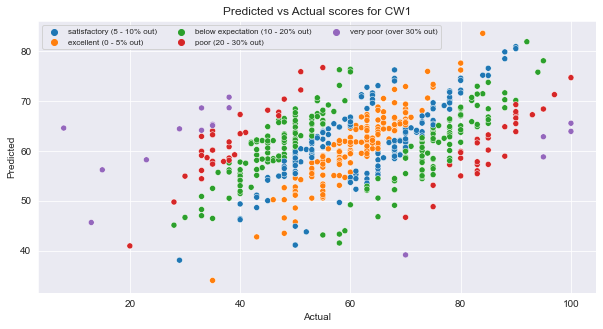

0.5670290533568816


<Figure size 432x288 with 0 Axes>

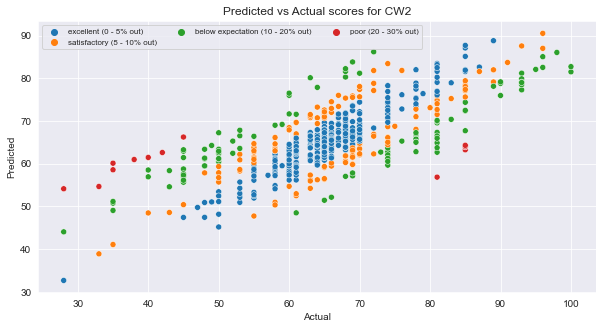

0.2990933449894472


<Figure size 432x288 with 0 Axes>

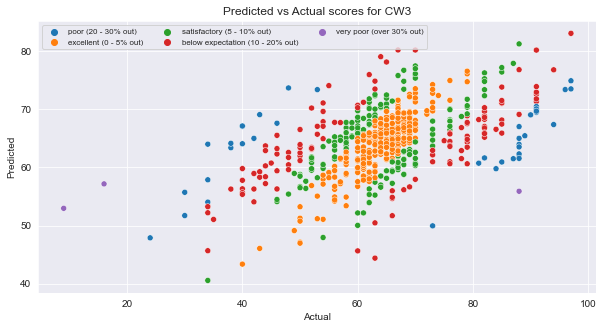

<Figure size 432x288 with 0 Axes>

In [23]:
#predict CW grades based on exam scores

features = np.array(ml_data[["EX1", "EX3R", "EX3W", "EX2"]])


labels_list = [(x, ml_data[x]) for x in ["CW1", "CW2", "CW3"]]

writer = pd.ExcelWriter("cw scores.xlsx", engine="xlsxwriter")

for assessment, labels in labels_list:
  model = LinearRegression()

  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


  model.fit(X_train, y_train)

  print(model.score(X_test, y_test))

  predicted = model.predict(X_test)


  df = pd.DataFrame({"Actual": y_test, "Predicted": predicted, "Difference": abs(y_test - predicted)})
  df["Accuracy"] = df["Difference"].apply(status)


  fig, ax = plt.subplots(figsize=(10, 5))
  sns.scatterplot(x="Actual", y="Predicted", data=df, hue="Accuracy", ax=ax)
  ax.set_title("Predicted vs Actual scores for {}".format(assessment))
  ax.legend(ncol=3, fontsize=8)
  plt.savefig("{}_p.png".format(assessment))
  plt.show()
  plt.clf()

  
  df.to_excel(writer, sheet_name=assessment, index=False)
  workbook = writer.book
  worksheet = writer.sheets[assessment]

  max_row, max_col = df.shape

  column_settings = [{"header": column} for column in df.columns]

  worksheet.add_table(0,0,max_row, max_col -1, {"columns": column_settings, "style": "Table Style Light 8"})
  worksheet.set_column(0, max_col, 30)
  worksheet.conditional_format("C2:C{}".format(max_row+1), {'type': '3_color_scale', 'min_color': '#46C616', 'mid_color': '#EFCC09', "max_color": '#D33020'})
  worksheet.insert_image("F1", "{}_p.png".format(assessment))


writer.save()



In [24]:
#make predictions based on initial IELTS
#fix non-numeric
#active_completed_students.drop(index=1250, inplace=True)

ml_data_2 = active_completed_students[["Entry IELTS Equiv. O", "IELTS Equiv.L", "IELTS Equiv.R", "IELTS Equiv.W", "IELTS Equiv. S", "EX1", "EX2", "EX3R", "EX3W", "CW1", "CW2", "CW3"]].reset_index(drop=True)

ml_data_2.rename({"Entry IELTS Equiv. O": "IELTS_Overall", "IELTS Equiv.L": "IELTS_Listening", "IELTS Equiv.R": "IELTS_Reading", "IELTS Equiv.W": "IELTS_Writing", "IELTS Equiv. S": "IELTS_Speaking"}, axis=1, inplace=True)



ml_data_2.replace(0, np.nan, inplace=True)
ml_data_2.dropna(how="any", inplace=True)

ml_data_2.drop(ml_data_2.index[np.where(ml_data_2["IELTS_Overall"] > 9)], inplace=True)
ml_data_2.reset_index(drop=True, inplace=True)


#data for ml
ielts_features = np.array(ml_data_2[["IELTS_Overall", "IELTS_Listening", "IELTS_Reading", "IELTS_Writing", "IELTS_Speaking"]])

ml_labels = [(x, np.array(ml_data_2[x])) for x in ["EX1", "EX2", "EX3R", "EX3W", "CW1", "CW2", "CW3"]]


dfs = []

writer = pd.ExcelWriter("predictions based on IELTS.xlsx", engine="xlsxwriter")
for assessment, labels in ml_labels:
  model = LinearRegression()
  X_train, X_test, y_train, y_test = train_test_split(ielts_features, labels, test_size=0.33, random_state=42)

  model.fit(X_train, y_train)

  print(model.score(X_test, y_test))

  predicted_scores = model.predict(X_test)
  

  if assessment == "EX1":
    df = pd.DataFrame({"IELTS Listening": X_test[:, 1], "{} Actual".format(assessment): y_test, "{} Predicted".format(assessment): predicted_scores, "{} Difference".format(assessment): abs(y_test - predicted_scores)})
  elif (assessment == "EX2") | (assessment == "CW2"):
    df = pd.DataFrame({"IELTS Speaking": X_test[:, 4], "{} Actual".format(assessment): y_test, "{} Predicted".format(assessment): predicted_scores, "{} Difference".format(assessment): abs(y_test - predicted_scores)})
  elif (assessment == "EX3R") | (assessment == "CW1"):
    df = pd.DataFrame({"IELTS Reading": X_test[:, 2], "{} Actual".format(assessment): y_test, "{} Predicted".format(assessment): predicted_scores, "{} Difference".format(assessment): abs(y_test - predicted_scores)})
  elif (assessment == "EX3W") | (assessment == "CW3"):
    df = pd.DataFrame({"IELTS Writing": X_test[:, 3], "{} Actual".format(assessment): y_test, "{} Predicted".format(assessment): predicted_scores, "{} Difference".format(assessment): abs(y_test - predicted_scores)})

  df["{} Accuracy".format(assessment)] = df["{} Difference".format(assessment)].apply(status)

  dfs.append(df)


  df.to_excel(writer, sheet_name=assessment, index=False)

  max_row, max_col = df.shape


  column_settings = [{"header": column} for column in df.columns]

  workbook = writer.book
  worksheet = writer.sheets[assessment]
  worksheet.set_column(0, max_col, 30)

  worksheet.add_table(0,0,max_row, max_col -1, {"columns": column_settings})

  worksheet.conditional_format("C2:C{}".format(max_row), {'type': '3_color_scale', 'min_color': '#46C616', 'mid_color': '#EFCC09', "max_color": '#D33020'})
  
  fig, axs = plt.subplots(figsize=(6,6))
  sns.countplot(x="{} Accuracy".format(assessment), data=df, order=df["{} Accuracy".format(assessment)].value_counts().index)
  axs.set_title("{} Prediction Accuracy".format(assessment))
  axs.set_xticklabels(labels=df["{} Accuracy".format(assessment)].unique(), rotation=45, ha="right")
  plt.tight_layout()
  plt.savefig("{}_fig.png".format(assessment))
  plt.clf()
  

  worksheet.insert_image("F1", "{}_fig.png".format(assessment))

writer.save()
  
all_preds = pd.concat(dfs, axis=1)

all_preds.to_excel("../all preds.xlsx")


0.3342650651142769
0.35566346086736633
0.3056552255931976
0.25199756876368373
0.08567019573383439
0.26734294847394524
0.1386215375835267


<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>